
# Project I- Submission
## Description:
Here I have used chest-xray-pneumonia image data set for the classification. Mostly the data set is taken from the kaggle and manual dataset for testing. I have used classical ML models like SVM, Random forest, logistic regression and other boosted forest models. I have tried to write clean code with proper comments.

The dataset is take directly from the kagglehub.


In [4]:
# instead of downloading the data, I have used following clipped code from kaggle to directly get the updated data.
!pip install -q kagglehub scikit-image xgboost seaborn

import kagglehub
import os

# Download latest version of the dataset
#  This will download the files and return the path to the folderr
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Dataset downloaded to:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Dataset downloaded to: /kaggle/input/chest-xray-pneumonia


In [5]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from skimage.feature import hog

# Importing scikit-learn models and other potential metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

print("Libraries imported successfully!")

Libraries imported successfully!


In [6]:
# --- Configuration ---
# Use os.path.join to correctly combine the downloaded path with subfolders
TRAIN_DATA_DIR = os.path.join(path, 'chest_xray/train')
TEST_DATA_DIR = os.path.join(path, 'chest_xray/test')
IMG_SIZE = (128, 128)
CLASSES = ['NORMAL', 'PNEUMONIA']

# --- Create a Pandas DataFrame for EDA ---
def create_dataframe(data_dir):
    image_paths = []
    labels = []
    for label in CLASSES:
        class_dir = os.path.join(data_dir, label)
        for img_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(label)
    return pd.DataFrame({'path': image_paths, 'label': labels})

# Create DataFrames for both training and testing sets
train_df = create_dataframe(TRAIN_DATA_DIR)
test_df = create_dataframe(TEST_DATA_DIR)

print("--- Training Data Info ---")
train_df.info()
print("\nFirst 5 rows of training data:")
print(train_df.head())

--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    5216 non-null   object
 1   label   5216 non-null   object
dtypes: object(2)
memory usage: 81.6+ KB

First 5 rows of training data:
                                                path   label
0  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
1  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
2  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
3  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
4  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL



Displaying one sample from each class:


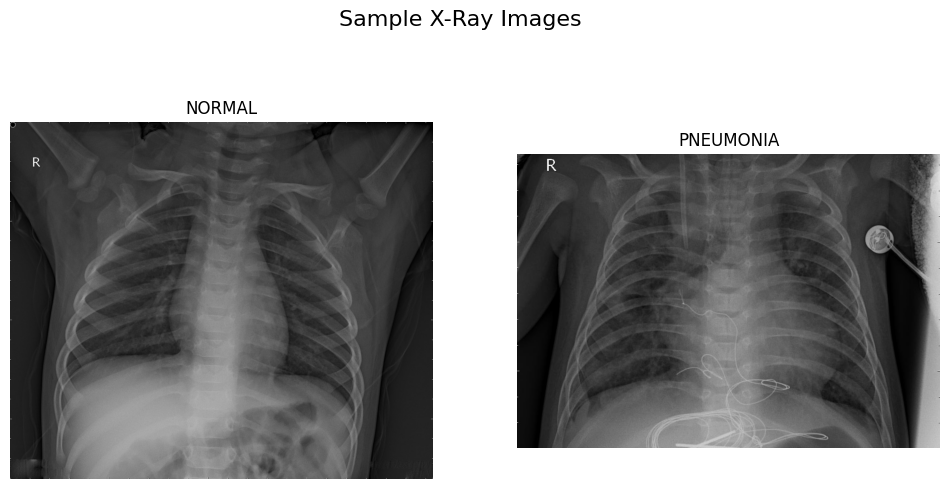

In [7]:
# Let us display the images..
def show_sample_images(df):
    plt.figure(figsize=(12, 6))

    # Here I am Showing  one 'NORMAL' image
    normal_img_path = df[df['label'] == 'NORMAL']['path'].iloc[0]
    normal_img = cv2.imread(normal_img_path)
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(normal_img, cv2.COLOR_BGR2RGB))
    plt.title('NORMAL')
    plt.axis('off')

    # Here I am Showing one 'PNEUMONIA' image
    pneumonia_img_path = df[df['label'] == 'PNEUMONIA']['path'].iloc[0]
    pneumonia_img = cv2.imread(pneumonia_img_path)
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(pneumonia_img, cv2.COLOR_BGR2RGB))
    plt.title('PNEUMONIA')
    plt.axis('off')

    plt.suptitle("Sample X-Ray Images", fontsize=16)
    plt.show()

print("\nDisplaying one sample from each class:")
show_sample_images(train_df)

In [8]:
def load_balanced_and_processed_data(data_dir, sample_size=None):
    """
    Loads images, creates a balanced subset by random sampling,
    preprocesses them, and extracts HOG features. This HOG is important for better feature extraction..
    """
    features = []
    labels = []

    print(f"\nProcessing data from: {data_dir}")
    for class_name in CLASSES:
        class_dir = os.path.join(data_dir, class_name)
        class_label = CLASSES.index(class_name)

        all_image_names = os.listdir(class_dir)

        # If a sample_size is given, randomly sample from the image list
        if sample_size:

            num_to_sample = min(sample_size, len(all_image_names))
            selected_images = random.sample(all_image_names, num_to_sample)
        else:
            selected_images = all_image_names # Use all images if no sample size

        print(f"Processing {len(selected_images)} images for class '{class_name}'...")
        for img_name in selected_images:
            try:
                img_path = os.path.join(class_dir, img_name)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                resized_image = cv2.resize(image, IMG_SIZE)
                normalized_image = resized_image / 255.0
                hog_features = hog(normalized_image, pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2), visualize=False)
                features.append(hog_features)
                labels.append(class_label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    print(f"\nSuccessfully created a dataset with {len(labels)} total images.")
    # Shuffle the data to mix NORMAL and PNEUMONIA samples
    combined = list(zip(features, labels))
    random.shuffle(combined)
    features[:], labels[:] = zip(*combined)

    return np.array(features), np.array(labels)

In [9]:
#  Calculate balance_size for balancing the training set
# Find the class with the fewest images in the training set
class_counts = train_df['label'].value_counts()
balance_size = class_counts.min()

print(f"\nMinority class count (balance_size): {balance_size}")


Minority class count (balance_size): 1341


In [10]:


# Create the balanced training set and the test set ---
# For the training set,, we use our calculated 'balance_size' for sampling
import random
X_train, y_train = load_balanced_and_processed_data(TRAIN_DATA_DIR, sample_size=balance_size)

# For the test set, we load all available images
X_test, y_test = load_balanced_and_processed_data(TEST_DATA_DIR)

# --- VERIFY THE BALANCE ---
print("\n--- Final Data Shapes ---")
print(f"Balanced training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

# This will print the counts of each class, which should now be identical for the training set
print(f"\nTraining set balance (Counts for NORMAL, PNEUMONIA): {np.bincount(y_train)}")


Processing data from: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Processing 1341 images for class 'NORMAL'...
Processing 1341 images for class 'PNEUMONIA'...

Successfully created a dataset with 2682 total images.

Processing data from: /kaggle/input/chest-xray-pneumonia/chest_xray/test
Processing 234 images for class 'NORMAL'...
Processing 390 images for class 'PNEUMONIA'...

Successfully created a dataset with 624 total images.

--- Final Data Shapes ---
Balanced training features shape: (2682, 8100)
Test features shape: (624, 8100)

Training set balance (Counts for NORMAL, PNEUMONIA): [1341 1341]


Visualizing HOG features for image: /kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1676_virus_2892.jpeg


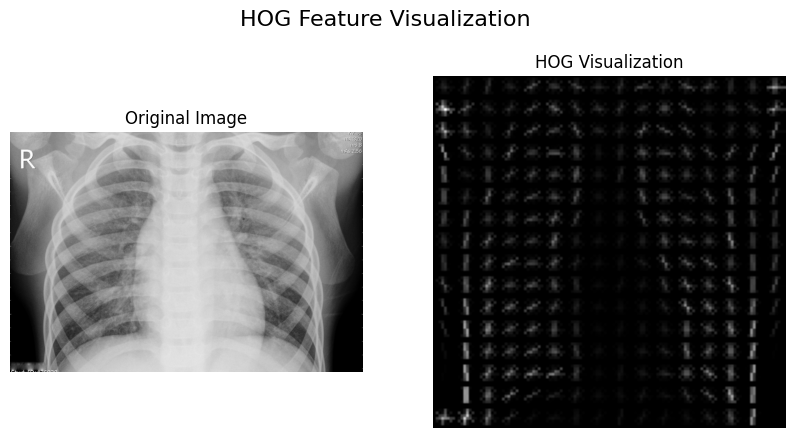

In [11]:
# --- Visualize HOG features for a sample image ---
def visualize_hog(image_path, img_size):
    """Loads an image, resizes it, extracts HOG features, and visualizes the HOG output."""
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        resized_image = cv2.resize(image, img_size)
        normalized_image = resized_image / 255.0

        # Calculate HOG features and the HOG visualization image
        hog_features, hog_image = hog(normalized_image, pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2), visualize=True)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG Visualization')
        plt.axis('off')

        plt.suptitle("HOG Feature Visualization", fontsize=16)
        plt.show()

    except Exception as e:
        print(f"Error visualizing HOG for {image_path}: {e}")

# Getting a sample image path for exaample.. a pneumonia image from the test set)
sample_image_path = test_df[test_df['label'] == 'PNEUMONIA']['path'].iloc[0]
print(f"Visualizing HOG features for image: {sample_image_path}")

# Visualize HOG for the sample image
visualize_hog(sample_image_path, IMG_SIZE)

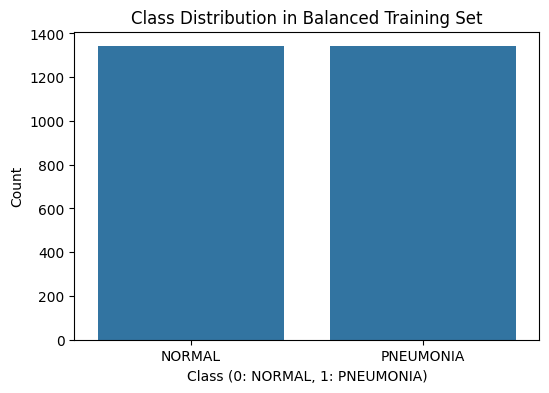

In [12]:
# --- Visualize the class distribution after balancing ---
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Class Distribution in Balanced Training Set')
plt.xlabel('Class (0: NORMAL, 1: PNEUMONIA)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['NORMAL', 'PNEUMONIA'])
plt.show()


--- Training Logistic Regression ---
Training time: 8.36 seconds
Accuracy: 0.7804

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.45      0.61       234
   PNEUMONIA       0.75      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.73       624
weighted avg       0.82      0.78      0.76       624



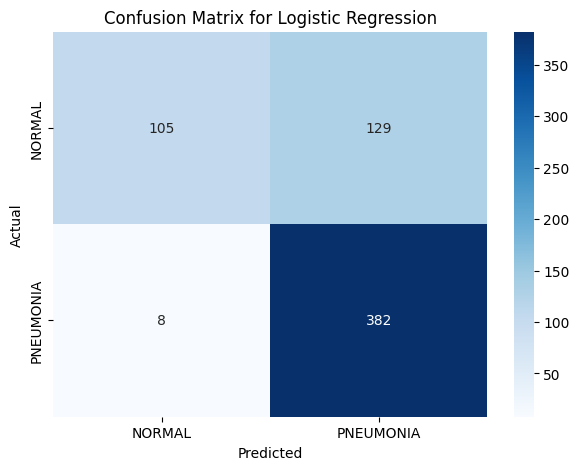


--- Training K-Nearest Neighbors ---
Training time: 0.03 seconds
Accuracy: 0.8221

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.79      0.72      0.75       234
   PNEUMONIA       0.84      0.88      0.86       390

    accuracy                           0.82       624
   macro avg       0.81      0.80      0.81       624
weighted avg       0.82      0.82      0.82       624



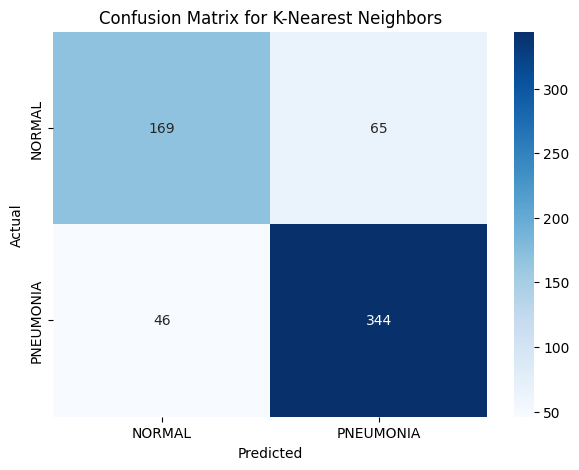


--- Training Support Vector Machine ---
Training time: 90.08 seconds
Accuracy: 0.7869

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.47      0.62       234
   PNEUMONIA       0.75      0.98      0.85       390

    accuracy                           0.79       624
   macro avg       0.84      0.72      0.74       624
weighted avg       0.82      0.79      0.77       624



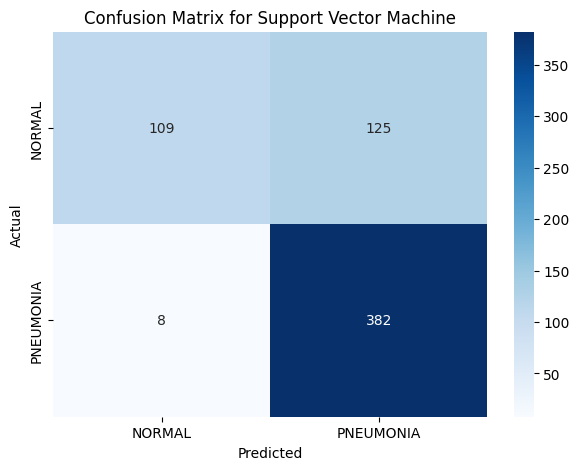


--- Training Random Forest ---
Training time: 35.41 seconds
Accuracy: 0.7901

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.85      0.53      0.66       234
   PNEUMONIA       0.77      0.94      0.85       390

    accuracy                           0.79       624
   macro avg       0.81      0.74      0.75       624
weighted avg       0.80      0.79      0.78       624



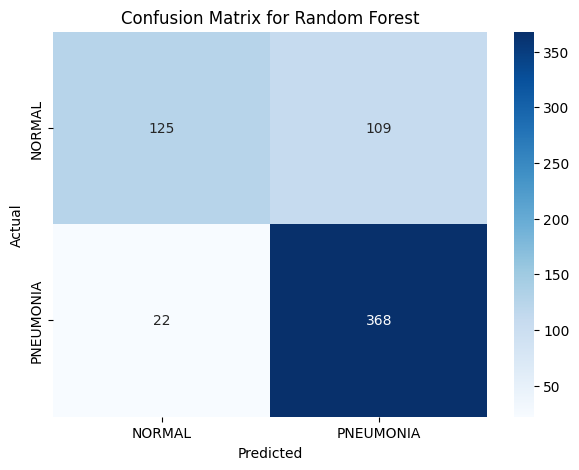


--- Training AdaBoost ---
Training time: 238.52 seconds
Accuracy: 0.7596

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.86      0.43      0.57       234
   PNEUMONIA       0.74      0.96      0.83       390

    accuracy                           0.76       624
   macro avg       0.80      0.69      0.70       624
weighted avg       0.78      0.76      0.73       624



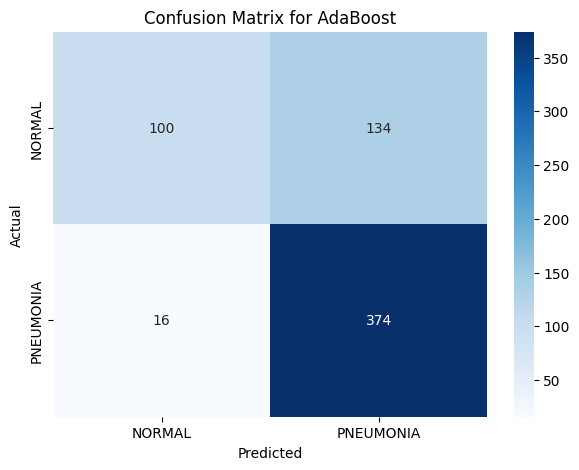


--- Training XGBoost ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:15:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training time: 98.21 seconds
Accuracy: 0.7708

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.89      0.44      0.59       234
   PNEUMONIA       0.74      0.97      0.84       390

    accuracy                           0.77       624
   macro avg       0.82      0.71      0.72       624
weighted avg       0.80      0.77      0.75       624



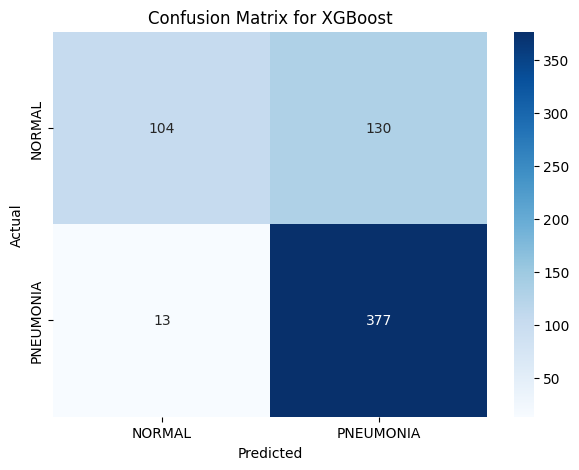


--- Training Gradient Boosting ---
Training time: 1220.08 seconds
Accuracy: 0.7660

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.88      0.44      0.58       234
   PNEUMONIA       0.74      0.96      0.84       390

    accuracy                           0.77       624
   macro avg       0.81      0.70      0.71       624
weighted avg       0.79      0.77      0.74       624



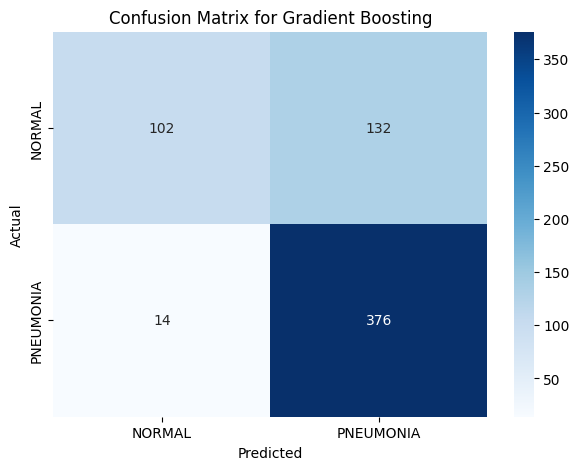

In [14]:
# Defining all models in a dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel='rbf', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# let us loop through the each model to train and evaluate
results = {}

for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    start_time = time.time()
    model.fit(X_train, y_train)
    print(f"Training time: {time.time() - start_time:.2f} seconds")

    # Making predictions and evaluating
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy

    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=CLASSES))

    # Plotting Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

/tmp/ipython-input-3538200584.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette='magma')


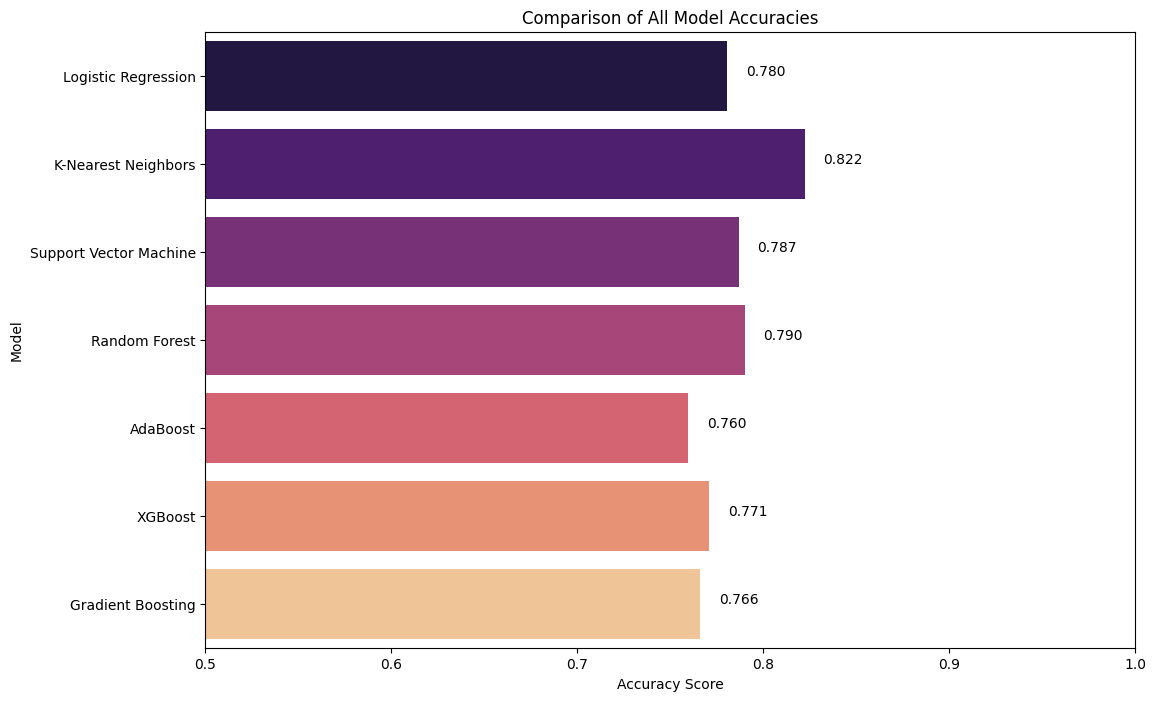

In [15]:
#Create a bar plot to compare model accuraciess
plt.figure(figsize=(12, 8))
model_names = list(results.keys())
accuracies = list(results.values())
sns.barplot(x=accuracies, y=model_names, palette='magma')
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.title('Comparison of All Model Accuracies')
plt.xlim(0.5, 1.0)

# Adding the accuracy values to the bars
for index, value in enumerate(accuracies):
    plt.text(value + 0.01, index, f'{value:.3f}')

plt.show()

Using the best model for final prediction: K-Nearest Neighbors


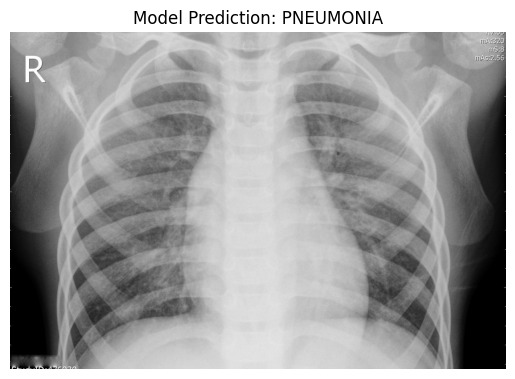

In [16]:
# now we have to do a single prediction on our test data..
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"Using the best model for final prediction: {best_model_name}")

# Get a sample image path from the test set
sample_image_path = test_df[test_df['label'] == 'PNEUMONIA']['path'].iloc[0]

# Preprocessing the single image just like the training data
image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
resized_image = cv2.resize(image, IMG_SIZE)
normalized_image = resized_image / 255.0
hog_features = hog(normalized_image, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)

# The model expects a 2D array, so we reshape our 1D feature vector
feature_vector = hog_features.reshape(1, -1)

# Make the prediction
prediction = best_model.predict(feature_vector)
predicted_class = CLASSES[prediction[0]]

# Display the result
original_image_for_display = cv2.imread(sample_image_path)
plt.imshow(cv2.cvtColor(original_image_for_display, cv2.COLOR_BGR2RGB))
plt.title(f"Model Prediction: {predicted_class}")
plt.axis('off')
plt.show()

In [17]:
import pickle
import os

# Define the filename for the model
model_filename = 'best_model.pkl'

# Save the best model to a file
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model saved to {model_filename}")

Best model saved to best_model.pkl


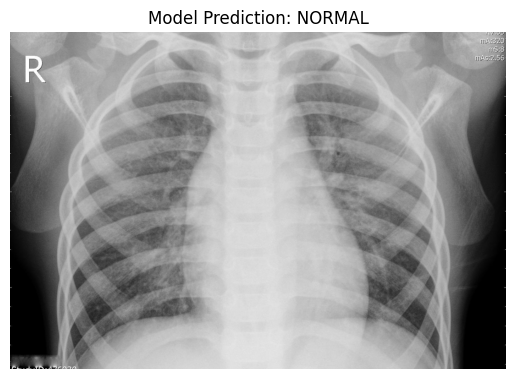

In [18]:

# Preprocessing the single image just like the training data
image = cv2.imread('/content/NORMAL2-IM-1440-0001.jpeg', cv2.IMREAD_GRAYSCALE)
resized_image = cv2.resize(image, IMG_SIZE)
normalized_image = resized_image / 255.0
hog_features = hog(normalized_image, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)

# The model expects a 2D array, so we reshape our 1D feature vector
feature_vector = hog_features.reshape(1, -1)

# Make the prediction
prediction = best_model.predict(feature_vector)
predicted_class = CLASSES[prediction[0]]

# Display the result
original_image_for_display = cv2.imread(sample_image_path)
plt.imshow(cv2.cvtColor(original_image_for_display, cv2.COLOR_BGR2RGB))
plt.title(f"Model Prediction: {predicted_class}")
plt.axis('off')
plt.show()

As we can see the model did correct prediction of the normal image.

# Improvements
1. The prediction could be checked using deep neural Networks.
2. We could deploy this code using the streamlit free deployment for easy usecase. In this way I can improve this project and could make it resume worthy.